Data project:

CAPM - financial data

Choose 2 stocks and market (SP-500)
1. Data
- Import stock data from csv/api
- Merge stock data together
- Calculate expected return matrix
- Calculate covariance matrix

2. CAPM Portfolio
- Find Minimum variance portfolio and Efficient tangent portfolio (Highest sharpe ratio).
- Plot portfolios in volatility-return diagram.
- Plot efficient market frontier and capital market line

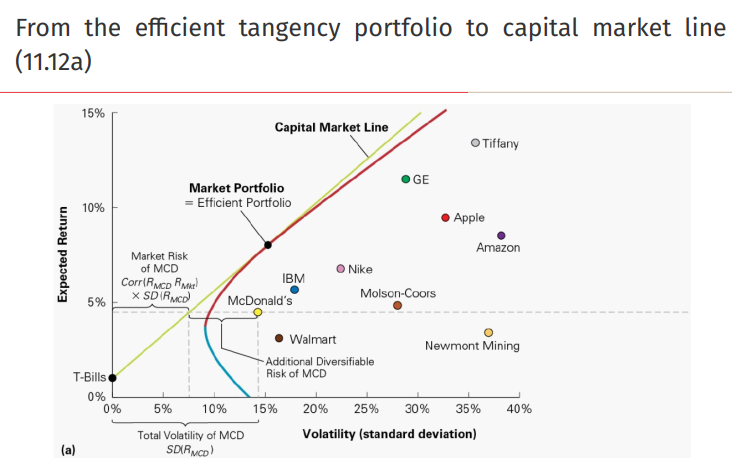

3. CAPM: Regression
- Import Fama/French market returns and risk free returns
- Clean Fama/French, fix dates
- Merge with Fama/French with returns
- Calculate market exposure/risk premium (Betas)
- Does CAPM hold? (Is alpha = 0)

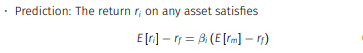




In [2]:
import yfinance as yf
import pandas as pd
import numpy as np


## 1.1) Importing data

In [152]:
# Importing monthly data from Yahoo Finance
data = yf.download(["^GSPC", "NVO", "MSFT"], start = "2020-01-01", end = "2024-04-08", interval = "1mo")
data = data["Adj Close"] # Only look at the adjusted close

# Calculate monthly returns
data['sp500_returns'] = data['^GSPC'].pct_change() * 100 
data["msft_returns"] = data["MSFT"].pct_change() * 100
data["nvo_returns"] = data["NVO"].pct_change() * 100
data = data.dropna() # First observation which is NA

print(data.head())

[*********************100%%**********************]  3 of 3 completed

Ticker            MSFT        NVO        ^GSPC  sp500_returns  msft_returns  \
Date                                                                          
2020-02-01  155.830811  27.309950  2954.219971      -8.411048     -4.828759   
2020-03-01  152.109161  28.282450  2584.590088     -12.511928     -2.388263   
2020-04-01  172.845627  29.752953  2912.429932      12.684404     13.632621   
2020-05-01  176.742126  30.979151  3044.310059       4.528182      2.254324   
2020-06-01  196.829300  30.763044  3100.290039       1.838840     11.365244   

Ticker      nvo_returns  
Date                     
2020-02-01    -4.438600  
2020-03-01     3.560973  
2020-04-01     5.199348  
2020-05-01     4.121266  
2020-06-01    -0.697587  


## 1.2 Return and covariance matrix

In [153]:
# Keep returns of Microsoft and Novo
returns = data.iloc[:, [4,5]]

# Calculate the average return over the period
return_matrix = np.mean(returns, axis = 0)
print(return_matrix)

Ticker
msft_returns    2.083592
nvo_returns     3.110162
dtype: float64


In [154]:
# Calculate covariance matrix
cov_matrix = returns.cov()
print(cov_matrix)
print("\n")

# Prints volatility
print(np.sqrt(cov_matrix))

Ticker        msft_returns  nvo_returns
Ticker                                 
msft_returns     42.703475    20.404266
nvo_returns      20.404266    36.678026


Ticker        msft_returns  nvo_returns
Ticker                                 
msft_returns      6.534790     4.517108
nvo_returns       4.517108     6.056239


## 2 Portfolios

In [93]:
def portfolio(w, return_matrix=return_matrix, cov_matrix=cov_matrix):
    '''Calculate expected returns and volatility (standard deviation) for given portfolio weights'''

    W = pd.DataFrame([w, 1-w], index=['msft_returns', 'nvo_returns']) # Creates weights
    tW = W.transpose() # Transposes weights
    var = tW.dot(cov_matrix).dot(W) # Formula for variance of portfolio
    sd = np.sqrt(var)[0][0] # take the square root
    e_r = tW.dot(return_matrix)[0] # Calculate the expected return

    return e_r, sd

## 2.1 Minimum Variance Portfolio

In [160]:
def mvp_w(N):
    '''Calculates the minimum variance portfolio for given return and covariance matrix'''

    # Create linear weight vector
    N = N
    w_vec = np.linspace(-1, 2, N)

    # Initial best volatility and weight
    vol_best = np.inf
    w_best = 0

    # Loops over all weight and saves the weight if the volatility is lower than before
    for w in w_vec:
        vol = portfolio(w)[1]
        if vol < vol_best:
            vol_best = vol
            w_best = w
    return w_best

In [162]:
w_min = mvp_w(100)
print(f'Minimum variance weights: w1 = {w_min:.3f}, w2 = {1 - w_min:.3f}\n')

mvp = portfolio(w_min)
print(f'MVP return = {mvp[0]:.3f}, MVP volatility = {mvp[1]:.3f}')

Minimum variance weights: w1 = 0.424, w2 = 0.576

MVP return = 2.675, MVP volatility = 5.460


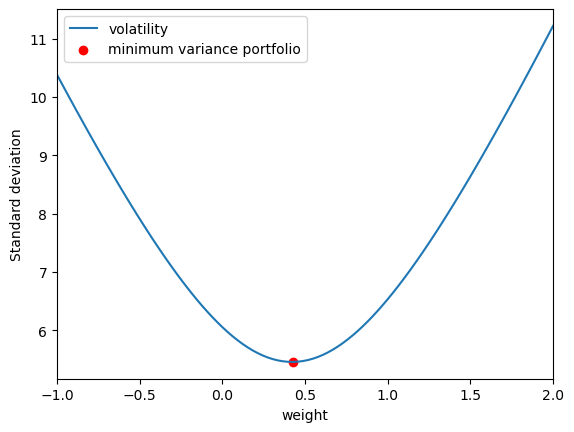

In [120]:
import matplotlib.pyplot as plt

# Generate the values for x, y, and z
w_values = np.linspace(-1, 2, 100)  # Varying values for the third input

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values of the function for each z value
function_values = []

for w in w_values:
    # Calculate the function values
    function_values.append(portfolio(w)[1]) 
    
# Plot functions value and optimum
ax.plot(w_values, function_values, label = "volatility")
ax.scatter(w_min, mvp[1], c = "red", label = "minimum variance portfolio")

# Add labels and a legend
ax.set_xlabel('weight')
ax.set_ylabel('Standard deviation')
ax.legend()

ax.set_xlim(-1, 2)
plt.show()


## 2.2 Efficient Tangent Portfolio

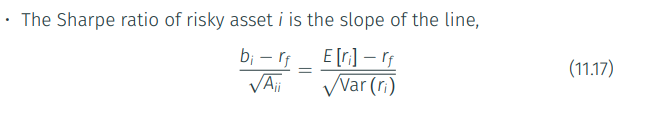

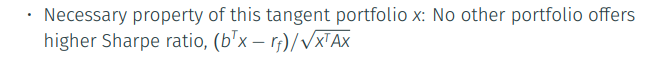

In [157]:
def sharpe_ratio(w, rf = 0):
    '''Calculate the sharpe ratio for any portfolio'''

    rf = rf # Risk free rate
    e_r, sd = portfolio(w) # Expected return and volatility

    sharpe = (e_r - rf)/sd
    return sharpe

In [158]:
def etp_w(N):
    '''Calculates Efficient Tangent Portfolio by finding the highest Sharpe ratio'''

    # Create linear weight vector
    N = N
    w_vec = np.linspace(-1, 2, N)

    # Initial best volatility and weight
    sharpe_best = -np.inf
    w_best = 0

    # Loops over all weight and saves the weight if the volatility is lower than before
    for w in w_vec:
        sharpe = sharpe_ratio(w)
        if sharpe > sharpe_best:
            sharpe_best = sharpe
            w_best = w
    return w_best

In [163]:
w_etp = etp_w(100)
print(f'Efficient tangent portfolio weights: w1 = {w_etp:.3f}, w2 = {1 - w_etp:.3f}\n')

etp = portfolio(w_etp)
print(f'ETP return = {etp[0]:.3f}, ETP volatility = {etp[1]:.3f}')

Efficient tangent portfolio weights: w1 = 0.121, w2 = 0.879

ETP return = 2.986, ETP volatility = 5.771


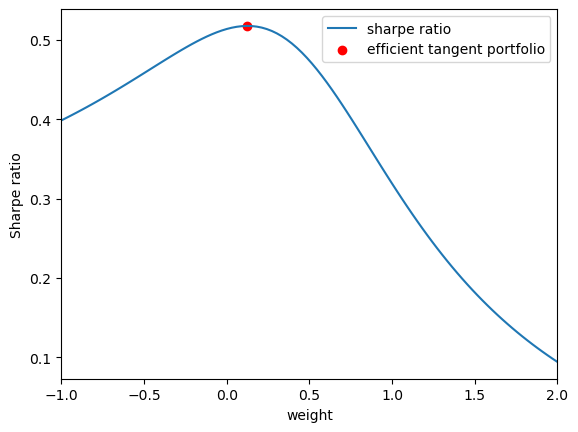

In [164]:
# Generate the values for x, y, and z
w_values = np.linspace(-1, 2, 100)  # Varying values for the third input

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values of the function for each z value
function_values = []

for w in w_values:
    # Calculate the function values
    function_values.append(sharpe_ratio(w)) 
    

ax.plot(w_values, function_values, label = "sharpe ratio")
ax.scatter(w_etp, sharpe_ratio(w_etp), c = "red", label = "efficient tangent portfolio")

# Add labels and a legend
ax.set_xlabel('weight')
ax.set_ylabel('Sharpe ratio')
ax.legend()

ax.set_xlim(-1, 2)
plt.show()


## 2.3 Efficient market frontier

In [207]:
mvp_weights = pd.DataFrame([w_min, 1 - w_min])
etp_weights = pd.DataFrame([w_etp, 1 - w_etp])

y_vec = np.linspace(-3, 3, 100)
lin_vec = []

for y in y_vec:
    linear = y*mvp_weights + (1-y)*etp_weights
    lin_vec.append(linear[0][0])

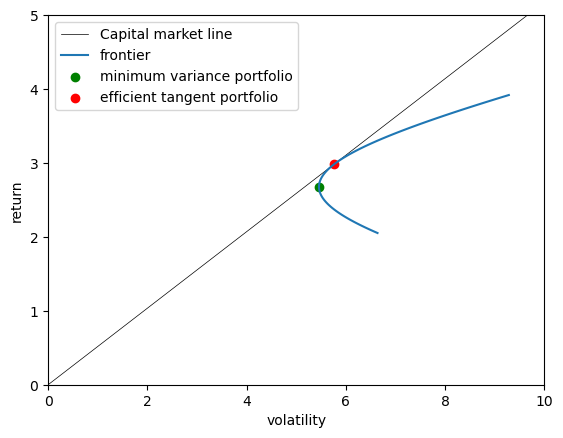

In [233]:
# Create a figure and axis
fig, ax = plt.subplots()

frontier = []

for l in lin_vec:
    # Calculate the function values
    frontier.append(portfolio(l)) 
    
return_values, vol_values = zip(*frontier)

rf = 0
point_rf = [0, rf]
point_etp = [etp[1], etp[0]]

# Compute the equation of the line passing through the two points
# y = mx + c, where m is the slope and c is the y-intercept
slope = (point_etp[1] - point_rf[1]) / (point_etp[0] - point_rf[0])
y_intercept = point_rf[1] - slope * point_rf[0]

# Generate x values for the line
x_values = np.linspace(0, 10, 100)
# Compute corresponding y values
y_values = slope * x_values + y_intercept

# Plot the points and the line passing through them
plt.plot(x_values, y_values, label='Capital market line', linewidth = 0.5, color = "black")


ax.plot(vol_values, return_values, label = "frontier")
#ax.scatter(0, rf, label = "risk free")
ax.scatter(mvp[1], mvp[0], c = "green", label = "minimum variance portfolio")
ax.scatter(etp[1], etp[0], c = "red", label = "efficient tangent portfolio")

# Add labels and a legend
ax.set_xlabel('volatility')
ax.set_ylabel('return')
ax.legend()

ax.set_xlim(0, 10)
ax.set_ylim(0, 5)
plt.show()
